# 1. Introduction

### 1.1 Motivation 

Forward uncertainty quantification (UQ) analysis aims to quantify the model prediction uncertainty given the input data uncertainties, which include model parameter uncertainties, initial condition uncertainties, boundary condition uncertainties, etc. It is called "forward" as the uncertainty information flows from the input, throught the model, to the output. Forward UQ analysis is a crucial step towards robust decision-making, as the reliability of the model prediction results is carefully examined by taking into account the input data variabilities. 

### 1.2 Objective

In this notebook, I will demonstrate how to perform a complete forward UQ analysis, starting with random sample generation, followed by uncertainty propagation, and ending with uncertainty visualization. 

### 1.3 Case study

The case study we will consider employs an epidemic model to predict the spread of a disease in a population. In this case study, the number of initial infected individuals (initial condition) and the infection rate (model parameter) are considered as uncertain input data. Our output of interests are the maximum number of infected individuals during the disease spreading and when that happens. 

Therefore, by performing forward UQ analysis, we could better understand how the output of interests will vary under the influence of the uncertain input data. This information is vital for supporting effective and robust decision-making in disease spreading control.

### 1.4 Notebook structure

We will start by introducing the problem statement of the current case study. Then, we will dive into the forward UQ analysis, which consists of the following three steps:

1. Random sample generation. In this step, we will create representative samples of the uncertain input parameters via a Latin Hypercube method.

2. Uncertainty propagation. In this step, we will employ a Monte Carlo approach to propagate uncertainty from the inputs to the outputs. 

3. Uncertainty visualization. In this step, we will visualize the output uncertainties using a technique called [**Hypothetical Outcome Plots**](https://towardsdatascience.com/uncertainty-visualization-made-easy-with-hypothetical-outcome-plots-89558574d069). 

Finally, we will discuss some of the challenges and possible solutions in performing forward UQ analysis in praactice.

In [3]:
# import all packages and set plots to be embedded inline
from pyDOE import lhs
from scipy.integrate import odeint
from scipy.stats.distributions import norm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
np.random.seed(42)

# 2. Problem Statement

### 2.1 Background 

In this case study, we model the spread of a disease in a population by using the **SIR** model. In its basic form, this model divides the total population $N$ into three distinct compartments that vary as functions of time $t$:

- $S(t)$, the number of individuals who are **S**usceptible but not yet infected with the disease;
- $I(t)$, the number of individuals who are **I**nfected;
- $R(t)$, the number of individuals who are have **R**ecovered from and immune to the disease.

The SIR model describes the time evolution of the $S(t), I(t)$ and $R(t)$ populations with the following system of ordinary differential equations:

\begin{align}
\frac{dS}{dt} &= -\frac{\beta SI}{N}, \\
\frac{dI}{dt} &= \frac{\beta SI}{N} - \gamma I, \\
\frac{dR}{dt} &= \gamma I,
\end{align}

where $\beta$ denotes the infection rate and $\gamma$ represents the recovery rate.

### 2.2 Uncertainty analysis



In [6]:
# Define the function to calculate S, I, R evolution
def SIR_model(beta, gamma, t, N, I0, R0):
    """The function implements the SIR model to calculate 
    the disease spreading.
    
    Input:
    - N: Population size
    - I0, R0: Initial infected individuals and recovered/immunity individuals
    - t: A grid of time points (in days)
    - beta: Infection rate
    - gamma: Recovery rate
    
    Output:
    - S: Number of susceptible individuals
    - I: Number of infected individuals
    - R: Number of recovered/immune individuals"""
    
    S0 = N - I0 - R0
    
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv, [S0, I0, R0], t, args=(N, beta, gamma))
    
    return ret.T 

In [29]:
beta, gamma = 0.23, 0.1

t = np.arange(0, 161)
S, I, R = SIR_model(beta, gamma, t, I0=8, N=1000, R0=0)

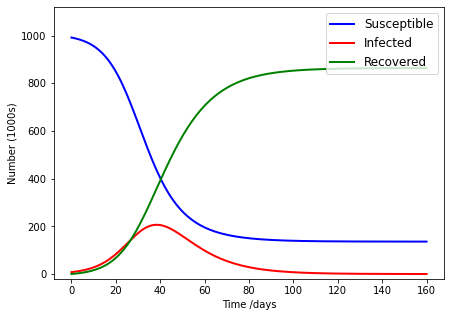

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(t, S, 'b', lw=2, label='Susceptible')
ax.plot(t, I, 'r', lw=2, label='Infected')
ax.plot(t, R, 'g', lw=2, label='Recovered')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(-20,1120)
ax.legend(loc="upper right",prop={'size': 12});

# 3. Random Sample Generation

In this step, we will use Latin Hypercube method to generate representative samples of the uncertain input parameters. Those generated samples will be used in the subsequent Monte Carlo simulation.

In [9]:
# Latin Hypercube sampling
sample_num = 1000
samples = lhs(2, samples=sample_num, criterion='maximin')

In [11]:
# Transform the samples to our target distributions

# Transform beta
beta_samples = norm(loc=0.23, scale=0.02).ppf(samples[:,0])

# Transform gamma
gamma_samples = norm(loc=0.1, scale=0.02).ppf(samples[:,1])

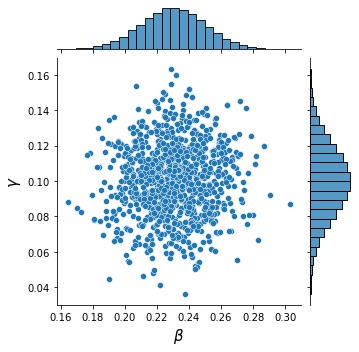

In [12]:
# Visualize samples
df_samples = pd.DataFrame({r"$\beta$":beta_samples,
                          r"$\gamma$":gamma_samples})

plt.rcParams["axes.labelsize"] = 15
sns.jointplot(data=df_samples, x=r"$\beta$", y=r"$\gamma$", height=5);

In [13]:
# Monte Carlo simulation
susceptible, infection, recovery = (np.zeros((t.shape[0], sample_num)) for i in range(3))

for i in range(sample_num):
    S, I, R= SIR_model(beta_samples[i], gamma_samples[i],
                       t, I0=8, N=1000, R0=0)
    
    susceptible[:,i] = S
    infection[:,i] = I
    recovery[:,i] = R

# Extract the output of interests
max_infection = infection.max(axis=0)  
max_time = infection.argmax(axis=0)

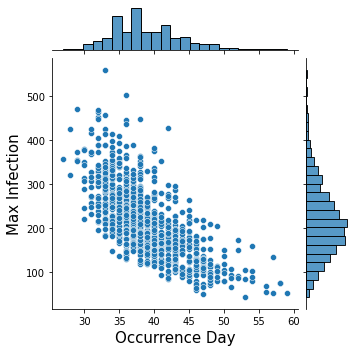

In [41]:
# Visualize samples
outputs = pd.DataFrame({"Max Infection":max_infection,
                          "Occurrence Day":max_time})

plt.rcParams["axes.labelsize"] = 15
sns.jointplot(data=outputs, x="Occurrence Day", y="Max Infection", height=5);